### Libraries

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Data filtering to get jakarta data only

In [32]:
## Read in data
prov = gpd.read_file("../data/low_res_sim.shp")  # Change path if needed
dist = gpd.read_file("../data/high_res_sim.shp")

In [33]:
dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry
0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2049.701351,0.123155,0.009869,0.394904,-0.198672,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2073.381185,0.123155,0.069135,0.437957,-0.198672,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2097.062716,0.123155,0.128646,0.459787,-0.198672,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2120.744248,0.123155,0.188616,0.481838,-0.198672,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1369.564318,0.079001,-1.038123,-0.069135,-0.459787,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [34]:
# get the unique district names
unique_districts = dist["District"].unique()
print(unique_districts)
jkt = ['KOTA JAKARTA BARAT',
 'KOTA JAKARTA PUSAT', 'KOTA JAKARTA SELATAN', 'KOTA JAKARTA TIMUR',
 'KOTA JAKARTA UTARA']

['BANDUNG' 'BANDUNG BARAT' 'BEKASI' 'BOGOR' 'CIAMIS' 'CIANJUR' 'CIREBON'
 'GARUT' 'INDRAMAYU' 'KARAWANG' 'KOTA BANDUNG' 'KOTA BANJAR' 'KOTA BEKASI'
 'KOTA BOGOR' 'KOTA CIMAHI' 'KOTA CIREBON' 'KOTA DEPOK'
 'KOTA JAKARTA BARAT' 'KOTA JAKARTA PUSAT' 'KOTA JAKARTA SELATAN'
 'KOTA JAKARTA TIMUR' 'KOTA JAKARTA UTARA' 'KOTA SUKABUMI'
 'KOTA TASIKMALAYA' 'KUNINGAN' 'MAJALENGKA' 'PANGANDARAN' 'PURWAKARTA'
 'SUBANG' 'SUKABUMI' 'SUMEDANG' 'TASIKMALAYA']


In [35]:
#filter df_combined to only retain observations in district = jkt list
jkt_dist = dist[dist["District"].isin(jkt)]

#filter for jkt_prov data
jkt_prov = prov[prov["Province"] == "DKI Jakarta"]

In [36]:
#print head
jkt_dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry
68,KOTA JAKARTA BARAT,2020,124.44,0.8138,DKI Jakarta,161,184826,1485.261974,0.951917,0.852925,0.128646,1.469371,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
69,KOTA JAKARTA BARAT,2021,124.44,0.8176,DKI Jakarta,138,183270,1472.757956,0.951917,1.004868,0.088935,1.469371,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
70,KOTA JAKARTA BARAT,2022,125.00,0.8251,DKI Jakarta,420,181715,1453.720000,0.951917,1.313613,0.069135,1.469371,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
71,KOTA JAKARTA BARAT,2023,125.00,0.8302,DKI Jakarta,359,180159,1441.272000,0.951917,1.530131,0.049363,1.469371,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
72,KOTA JAKARTA PUSAT,2020,52.38,0.8139,DKI Jakarta,127,73140,1396.334479,0.993514,0.881675,-0.029610,5.199338,"POLYGON ((106.83247 -6.14138, 106.83282 -6.141..."


<Axes: >

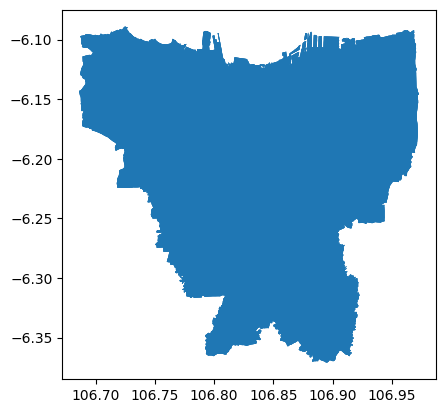

In [37]:
#try plotting the map alone
jkt_dist.plot()

<Axes: >

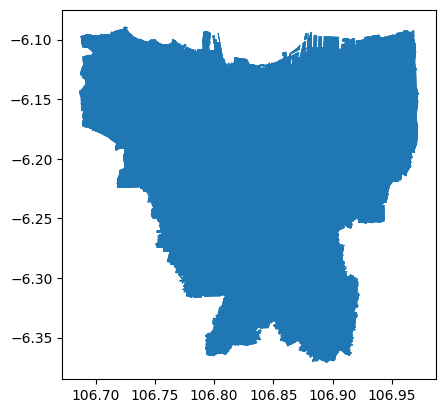

In [38]:
jkt_prov.plot()

In [40]:
# save as jkt combined divisions so next time dont need to filter again
jkt_dist.to_file("../data/jkt_dist.shp")
jkt_prov.to_file("../data/jkt_prov.shp")